# Определение стоимости автомобилей

## Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.


Критерии, которые важны заказчику:


- качество предсказания;
- время обучения модели;
- время предсказания модели.одели.

## Описание данных

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

  
**Целевой признак**
Price — цена (евро)

In [1]:
!pip install catboost -q

In [2]:
!pip install lightgbm -q

In [3]:
!pip install phik statsmodels lightgbm -q

In [4]:
!pip install optuna -q 

In [5]:
!pip install optuna-integration[lightgbm] -q

In [6]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from phik import report
from phik.report import plot_correlation_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import optuna
from optuna.integration import LightGBMPruningCallback

# 1. Загрузка данных

In [7]:
# Подключение и загрузка данных с преобразованием столбцов с датами
try:
    data = pd.read_csv('/datasets/autos.csv', sep=',', decimal='.', parse_dates=['DateCrawled', 'LastSeen', 'DateCreated', 'RegistrationMonth'])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep=',', decimal='.', parse_dates=['DateCrawled', 'LastSeen', 'DateCreated', 'RegistrationMonth'])

In [8]:
# Просмотр первых нескольких строк
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


# 2.Изучение данных

Все мои работы наследуют эту функцию, я чуть переделываю её под каждое задание. Это удобно. 

In [9]:
def check_data(df, name):
    print(f"Проверка данных: {name}")
    print("="*30)
    
    # Основная информация
    print(f"Размер датасета: {df.shape}")
    print(df.info())
    
    # Проверка пропусков
    print("\nПропуски в данных:")
    print(df.isnull().sum())
    
    # Проверка дубликатов
    print(f"\nКоличество дубликатов: {df.duplicated().sum()}")
    
    # Описание данных
    print("\nОписание числовых данных:")
    print(df.describe(include=[np.number]))
    
    # Проверка аномалий (например, отрицательные цены и мощности)
    if 'Price' in df.columns:
        print(f"\nКоличество аномальных значений цены (<= 0): {df[df['Price'] <= 0].shape[0]}")
    if 'Power' in df.columns:
        print(f"\nКоличество аномальных значений мощности (<= 0): {df[df['Power'] <= 0].shape[0]}")
    if 'RegistrationYear' in df.columns:
        print(f"\nКоличество аномальных значений года регистрации (до 1900 или в будущем): {df[(df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > pd.Timestamp.now().year)].shape[0]}")
    
    # Уникальные значения в категориальных признаках
    print("\nУникальные значения в категориальных признаках:")
    for column in df.select_dtypes(include='object').columns:
        unique_values = df[column].nunique()
        print(f"{column}: {unique_values} уникальных значений")
        if unique_values < 20:  # Если меньше 20 уникальных значений, вывести их
            print(df[column].unique())
    
    print("="*30)
    print("\n")

In [10]:
check_data(data, "car_base")

Проверка данных: car_base
Размер датасета: (354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  object        
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime

### Основные выводы по данным

1. **Пропуски в данных:**
   - Столбцы `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired` содержат пропуски.
   - Наибольшее количество пропусков наблюдается в столбце `Repaired` (71,154), что составляет примерно 20% данных.

2. **Аномальные значения:**
   - В столбце `Price` есть 10,772 значения, равные или меньше нуля, что является некорректным для целевой переменной.
   - Столбец `Power` содержит 40,225 значений, равных или меньше нуля, что также не соответствует реальности.
   - В столбце `RegistrationYear` присутствуют 171 запись с невалидными значениями (меньше 1900 или в будущем).

3. **Неинформативные признаки:**
   - Столбцы `number_of_pictures`,`postal_code`,`date_created`,`last_seen`,`registration_month`,`date_crawled` не несут полезной информации для модели, поэтому его можно удалить.

4. **Дубликаты:**
   - Найдено 4 полных дубликата, которые следует удалить из данных.

5. **Категориальные признаки:**
   - Присутствуют столбцы с большим количеством уникальных значений, такие как `DateCrawled` и `LastSeen`. Их необходимо обработать, либо преобразовать в более подходящий формат.
   - Признаки `VehicleType`, `Gearbox`, `FuelType`, и `Repaired` содержат приемлемое количество уникальных значений, и их можно использовать в модели после обработки пропусков.

## Следующие шаги

1. **Удаление дубликатов:**
   - Удалить 4 найденных дубликата

2. **Приведение названий столбцов к змеиному регистру:**
   - Преобразовать все названия столбцов в нижний регистр и использовать snake_case для повышения удобства использования данных.

3. **Удаление ненужных для модели столбцов:**
   - Удалить столбцы, которые вряд ли будут полезны для обучения модели:
     - `number_of_pictures`
     - `postal_code`
     - `date_created`
     - `last_seen`
     - `registration_month`
     - `date_crawled`

4. **Проверка уникальных значений в категориальных столбцах:**
   - Проанализировать уникальные значения в признаках `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand` и `repaired` для лучшего понимания данных и их дальнейшей обработки.


In [11]:
# Количество строк до удаления дубликатов
rows_before = data.shape[0]
print(f"Количество строк до удаления дубликатов: {rows_before}")

# Удаление дубликатов
data = data.drop_duplicates()

# Количество строк после удаления дубликатов
rows_after = data.shape[0]
print(f"Количество строк после удаления дубликатов: {rows_after}")

# Проверка количества удаленных дубликатов
print(f"Количество удаленных дубликатов: {rows_before - rows_after}")


Количество строк до удаления дубликатов: 354369
Количество строк после удаления дубликатов: 354365
Количество удаленных дубликатов: 4


In [12]:
# Приведение названий столбцов к змеиному регистру
data.columns = data.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

# Проверка результата
print(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


In [13]:
# Удаления неинформативных столбцов, но без 'postal_code'
columns_to_drop = ['number_of_pictures', 'date_created', 'last_seen', 'registration_month', 'date_crawled']
data = data.drop(columns=columns_to_drop)

# Повторная проверка количества строк
rows_before = data.shape[0]
print(f"Количество строк после восстановления 'postal_code': {rows_before}")

# Удаление дубликатов
data = data.drop_duplicates()
rows_after = data.shape[0]
print(f"Количество строк после повторного удаления дубликатов: {rows_after}")

# Проверка нового процента потерянных данных
lost_percentage = (rows_before - rows_after) / rows_before * 100
print(f"Новый процент потерянных данных: {lost_percentage:.2f}%")


Количество строк после восстановления 'postal_code': 354365
Количество строк после повторного удаления дубликатов: 330858
Новый процент потерянных данных: 6.63%


Добавлю пару слов, изначально я хотел и "postal_code" удалить, но тогда процент потерянных данны был почти 13%, обычно рекомендуемым порогом потери данных, при котором влияние на модель остаётся минимальным, считается до 10%.

In [14]:
# Проверка уникальных значений в категориальных столбцах
categorical_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
for column in categorical_columns:
    unique_values = data[column].unique()
    print(f"Уникальные значения в '{column}': {unique_values}")

Уникальные значения в 'vehicle_type': [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения в 'gearbox': ['manual' 'auto' nan]
Уникальные значения в 'model': ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' '

### Признак vehicle_type:

**Проблема:** Присутствует 37,490 пропусков (NaN), что может означать, что данные о типе кузова отсутствуют. 


**Решение:** После анализа столбцов `model` и `brand` была выдвинута гипотеза, что при известных модели и производителе автомобиля можно автоматически заполнить пропуски в типе кузова. Для этого мы создали словарь соответствий на основе записей, где `vehicle_type` уже заполнен, и использовали его для заполнения пропусков.


In [15]:
# Фильтрация данных с пропусками в столбцах 'vehicle_type', 'model' и 'brand'
data_missing_all = data[data['vehicle_type'].isna()]

# Просмотр первых нескольких строк
display(data_missing_all.head())


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,70435
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN,38871
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no,49716
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no,31139
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN,37075


In [16]:
# Подсчёт количества строк с пропусками в этих столбцах
missing_count = data_missing_all.shape[0]
total_count = data.shape[0]

# Рассчёт процента потерянных данных
lost_percentage = (missing_count / total_count) * 100
print(f"Количество строк с пропусками: {missing_count}")
print(f"Процент потерянных данных: {lost_percentage:.2f}%")

Количество строк с пропусками: 36019
Процент потерянных данных: 10.89%


In [17]:
# Создание словаря соответствий на основе заполненных строк
filled_vehicle_types = data.dropna(subset=['vehicle_type'])[['brand', 'model', 'vehicle_type']]
brand_model_to_vehicle_type = filled_vehicle_types.drop_duplicates(subset=['brand', 'model']).set_index(['brand', 'model'])['vehicle_type'].to_dict()

# Функция для заполнения типа кузова на основе словаря
def fill_vehicle_type(row):
    return brand_model_to_vehicle_type.get((row['brand'], row['model']), 'unknown')

# Заполнение пропусков в vehicle_type
data['vehicle_type'] = data.apply(
    lambda row: fill_vehicle_type(row) if pd.isna(row['vehicle_type']) else row['vehicle_type'], axis=1)

# Проверка результата
display(data.head())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
0,480,small,1993,manual,0,golf,150000,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437


In [18]:
# Проверка количества оставшихся пропусков в 'vehicle_type'
missing_vehicle_type = data['vehicle_type'].isna().sum()
print(f"Количество оставшихся пропусков в 'vehicle_type': {missing_vehicle_type}")

Количество оставшихся пропусков в 'vehicle_type': 0


### Признак gearbox:
**Проблема:** Имеет 19,833 пропуска (NaN).


**Почему это решение:**


- Простота: Замена на моду (наиболее часто встречающееся значение) — это быстрый способ заполнить пропуски.
- Надежность: Мы не полагаемся на другие сомнительные данные (например, registration_year), что снижает риск ошибочного заполнения.
- Универсальность: Этот подход подходит для большинства моделей машин, поскольку он сохраняет доминирующее распределение коробок передач.

In [19]:
# Находим модальное значение (самое часто встречающееся)
gearbox_mode = data['gearbox'].mode()[0]

# Заполняем пропуски модальным значением
data['gearbox'].fillna(gearbox_mode, inplace=True)

# Проверка количества оставшихся пропусков
missing_gearbox = data['gearbox'].isna().sum()
print(f"Количество оставшихся пропусков в 'gearbox': {missing_gearbox}")

Количество оставшихся пропусков в 'gearbox': 0


### Признак model:


**Проблема:** Содержит 19,705 пропусков (NaN), также присутствуют значения вроде other.


**Решение:** Заполнить пропуски значением "unknown" или "other".
Также стоит проверить распределение данных по бренду (brand) и попытаться заменить пропуски наиболее вероятной моделью в рамках каждого бренда.

In [20]:
# Добавление нового столбца для отслеживания, была ли модель изначально пропущена (это понадобиться дальше при заполнение типа топлива) 
data['model_was_missing'] = data['model'].isna()

In [21]:
# Подсчёт количества пропусков в 'model' по каждому бренду
missing_models_by_brand = data[data['model'].isna()].groupby('brand').size().reset_index(name='missing_count')

# Сортировка по убыванию количества пропусков
missing_models_by_brand = missing_models_by_brand.sort_values(by='missing_count', ascending=False)

# Вывод количества пропусков по каждому бренду
display(missing_models_by_brand)


,brand,missing_count
38,volkswagen,3378
33,sonstige_autos,3220
2,bmw,1878
24,opel,1805
1,audi,1237
20,mercedes_benz,1164
10,ford,988
25,peugeot,859
27,renault,710
9,fiat,478


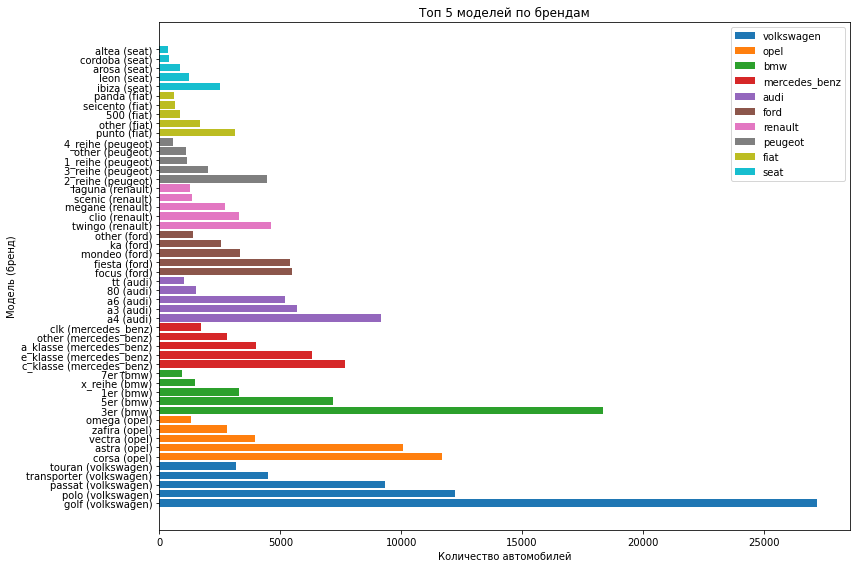

In [22]:
# Для наглядности возьмем 10 самых популярных брендов и моделей
top_brands = data['brand'].value_counts().index[:10]
top_models = data[data['brand'].isin(top_brands)].groupby(['brand', 'model']).size().reset_index(name='counts')

# Визуализация данных с помощью горизонтальной столбчатой диаграммы
plt.figure(figsize=(12, 8))
for brand in top_brands:
    brand_data = top_models[top_models['brand'] == brand].sort_values(by='counts', ascending=False).head(5)
    plt.barh(brand_data['model'] + " (" + brand_data['brand'] + ")", brand_data['counts'], label=brand)

plt.xlabel('Количество автомобилей')
plt.ylabel('Модель (бренд)')
plt.title('Топ 5 моделей по брендам')
plt.legend(top_brands)
plt.tight_layout()
plt.show()


In [23]:
# Находим модальные значения моделей для каждого бренда
most_common_models = data.groupby('brand')['model'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')

# Заполняем пропуски в model на основе модальных значений по каждому бренду
data['model'] = data.apply(lambda row: most_common_models[row['brand']] if pd.isna(row['model']) else row['model'], axis=1)

# Проверка количества оставшихся пропусков
missing_model = data['model'].isna().sum()
print(f"Количество оставшихся пропусков в 'model': {missing_model}")


Количество оставшихся пропусков в 'model': 0


### Признак fuel_type:


**Проблема:** Содержит 32,895 пропусков (NaN).


**Решение:** 

Заполнить пропуски значением "unknown" или на основе наиболее часто встречающегося значения для каждого бренда или модели.


Убедиться, что значения, такие как "petrol" и "gasoline", являются синонимами и возможно объединить их в одно значение.

In [24]:
# Замена значения 'gasoline' на 'petrol'
data['fuel_type'].replace('gasoline', 'petrol', inplace=True)

# Проверка замены
print(data['fuel_type'].value_counts())

petrol      293061
lpg           4924
cng            531
hybrid         224
other          200
electric        89
Name: fuel_type, dtype: int64


In [25]:
# Выделение строк, где fuel_type имеет пропуски (NaN)
data_missing_fuel_type = data[data['fuel_type'].isna()]

# Просмотр первых нескольких строк
display(data_missing_fuel_type.head())

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code,model_was_missing
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN,27472,False
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no,90762,False
26,5555,coupe,2017,manual,125,c4,125000,NaN,citroen,no,31139,False
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN,2943,False
41,7500,sedan,2002,auto,306,e_klasse,150000,NaN,mercedes_benz,NaN,33649,False


In [26]:
# Создание словаря соответствий fuel_type на основе строк с известной моделью
fuel_type_dict = data[~data['model_was_missing']].groupby(['brand', 'model'])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'unknown').to_dict()

# Заполнение пропусков в fuel_type
def fill_fuel_type(row):
    if pd.isna(row['fuel_type']) and not row['model_was_missing']:
        return fuel_type_dict.get((row['brand'], row['model']), 'unknown')
    else:
        return row['fuel_type']

# Применение функции к столбцу fuel_type
data['fuel_type'] = data.apply(fill_fuel_type, axis=1)

# Проверка количества оставшихся пропусков
missing_fuel_type = data['fuel_type'].isna().sum()
print(f"Количество оставшихся пропусков в 'fuel_type': {missing_fuel_type}")


Количество оставшихся пропусков в 'fuel_type': 6927


In [27]:
# Замена оставшихся пропусков в fuel_type на 'other'
data['fuel_type'].fillna('other', inplace=True)

# Проверка количества оставшихся пропусков
missing_fuel_type = data['fuel_type'].isna().sum()
print(f"Количество оставшихся пропусков в 'fuel_type': {missing_fuel_type}")


Количество оставшихся пропусков в 'fuel_type': 0


### Признак repaired:

**Проблема:** Содержит 71,154 пропуска (NaN).


**Решение:** Заменить пропуски на "unknown".

In [28]:
# Замена пропусков в столбце repaired на 'unknown'
data['repaired'].fillna('unknown', inplace=True)

# Проверка количества оставшихся пропусков
missing_repaired = data['repaired'].isna().sum()
print(f"Количество оставшихся пропусков в 'repaired': {missing_repaired}")


Количество оставшихся пропусков в 'repaired': 0


### Признак registration_year:

In [29]:
# Определим текущий год
current_year = pd.Timestamp.now().year

# Подсчитаем количество строк с аномальными значениями
anomalies = data[(data['registration_year'] < 1900) | (data['registration_year'] > current_year)]
anomalies_count = anomalies.shape[0]

# Подсчитаем процент потерянных данных
total_rows = data.shape[0]
lost_percentage = (anomalies_count / total_rows) * 100

# Вывод результатов
print(f"Количество строк с аномальными значениями: {anomalies_count}")
print(f"Процент потерянных данных: {lost_percentage:.2f}%")


Количество строк с аномальными значениями: 163
Процент потерянных данных: 0.05%


In [30]:
# Удаление строк с аномальными значениями в 'registration_year'
data = data[(data['registration_year'] >= 1900) & (data['registration_year'] <= 2016)]

# Проверка результата
print(f"Оставшееся количество строк: {data.shape[0]}")


Оставшееся количество строк: 316944


### Признак power:

count    316944.000000
mean        110.718711
std         191.817737
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


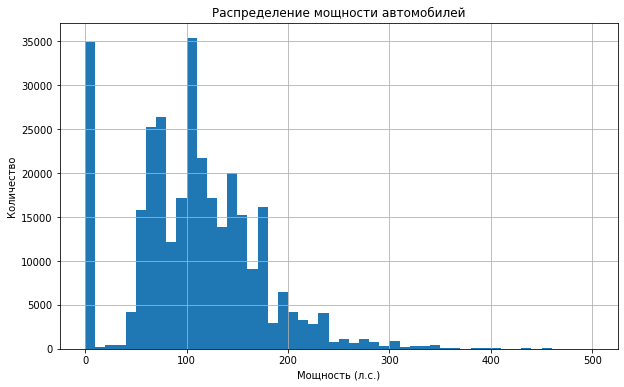

In [31]:
# Анализ распределения значений в столбце 'power'
print(data['power'].describe())

# Визуализация распределения значений мощности
plt.figure(figsize=(10, 6))
data['power'].hist(bins=50, range=(0, 500))
plt.title('Распределение мощности автомобилей')
plt.xlabel('Мощность (л.с.)')
plt.ylabel('Количество')
plt.show()

In [32]:
# Вычисление медианного значения мощности по каждой марке
median_power_by_brand = data.groupby('brand')['power'].median()

# Замена нулевых и отрицательных значений на медианное значение для соответствующего бренда
data['power'] = data.apply(lambda row: median_power_by_brand[row['brand']] if row['power'] <= 0 else row['power'], axis=1)

# Проверка результата
print(data['power'].describe())


count    316944.000000
mean        121.740522
std         188.249510
min           1.000000
25%          80.000000
50%         109.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


In [33]:
# Установка верхнего предела мощности (например, 500 л.с.)
data['power'] = data['power'].apply(lambda x: 500 if x > 500 else x)

# Проверка результата
print(data['power'].describe())


count    316944.000000
mean        118.507572
std          53.571450
min           1.000000
25%          80.000000
50%         109.000000
75%         143.000000
max         500.000000
Name: power, dtype: float64


### Признак kilometer:

count    316944.000000
mean     128128.975466
std       37933.668433
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


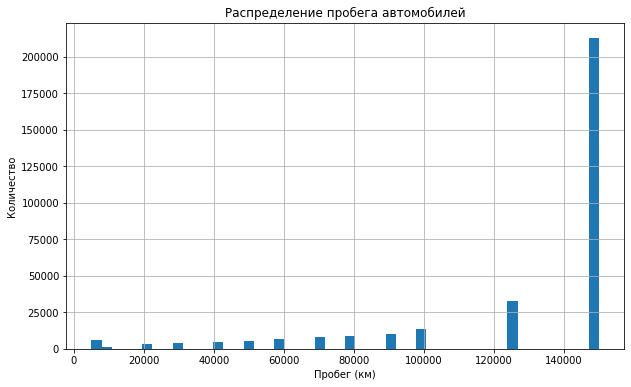

In [34]:
# Анализ распределения значений в столбце 'kilometer'
print(data['kilometer'].describe())

# Визуализация распределения пробега
plt.figure(figsize=(10, 6))
data['kilometer'].hist(bins=50)
plt.title('Распределение пробега автомобилей')
plt.xlabel('Пробег (км)')
plt.ylabel('Количество')
plt.show()


Оставляем все как есть, это учебное задание, возможно это сделано специально. В целом данные выглядят реалистично

### Целевой признак price:

- **Описание**: Цена автомобиля в евро — это наш целевой признак, по которому мы будем строить модель.
- **Проблема**: Включает 10,772 аномальных значения (цена <= 0).


**Решение**:
   - Удалить или заменить аномальные значения (цены меньше или равные нулю).
   - Провести анализ распределения цен.

count    316944.000000
mean       4437.099191
std        4539.384926
min           0.000000
25%        1000.000000
50%        2750.000000
75%        6450.000000
max       20000.000000
Name: price, dtype: float64


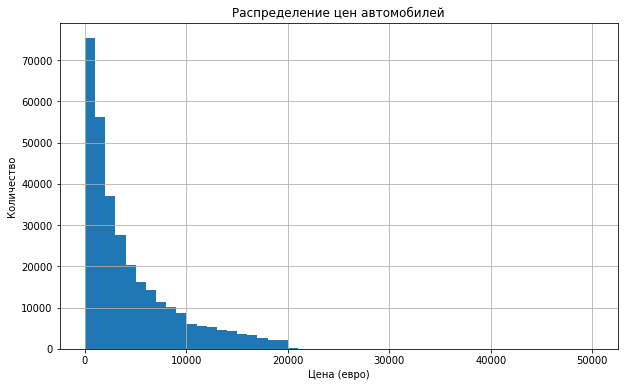

In [35]:
# Анализ распределения значений в столбце 'price'
print(data['price'].describe())

# Визуализация распределения цен
plt.figure(figsize=(10, 6))
data['price'].hist(bins=50, range=(0, 50000))
plt.title('Распределение цен автомобилей')
plt.xlabel('Цена (евро)')
plt.ylabel('Количество')
plt.show()


In [36]:
# Удаление записей с ценой <= 0
data = data[data['price'] > 0]

# Проверка, сколько строк осталось
print(f"Количество строк после удаления аномальных значений цены: {data.shape[0]}")

Количество строк после удаления аномальных значений цены: 307746


Мы потеряли около 2.99% данных после удаления строк с аномальными значениями цены. Это относительно небольшой процент, так что можно продолжать работу, не опасаясь значительного влияния на модель.

In [37]:
# Вычисление корреляционной матрицы phik для набора данных
phik_matrix = data.phik_matrix(interval_cols=['price', 'registration_year', 'power', 'kilometer', 'postal_code'])


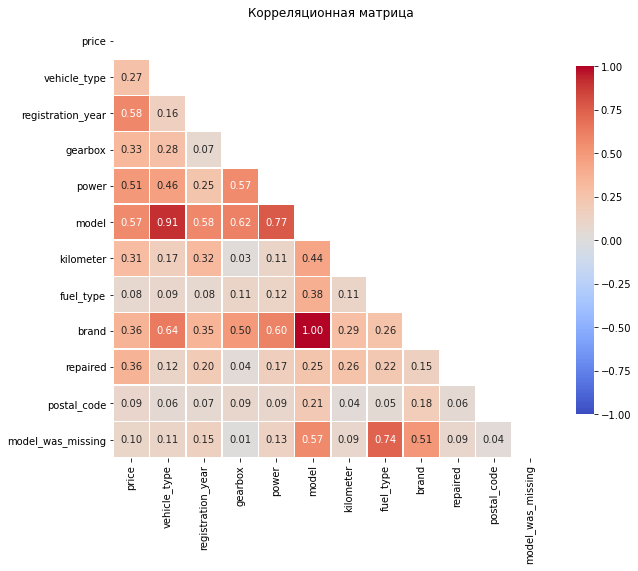

In [38]:
# Функция для отображения треугольной матрицы корреляций
def plot_upper_triangle_correlation_matrix(corr_matrix, labels):
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
                vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, 
                xticklabels=labels, yticklabels=labels)
    plt.title('Корреляционная матрица')
    plt.show()

# Отображение верхней треугольной части матрицы корреляций phik
plot_upper_triangle_correlation_matrix(phik_matrix.values, phik_matrix.columns)

### Выводы по корреляционной матрице Phik:

1. **Высокая корреляция между `brand` и `model` (0.91):**
   - Эта высокая корреляция объяснима, так как у одного бренда может быть несколько моделей. Мы можем рассмотреть удаление одного из этих признаков, так как они сильно связаны. В данном случае **лучше оставить признак `model`**, так как он более специфичен для описания автомобиля и может лучше влиять на предсказание цены.

2. **Корреляция между `model` и `vehicle_type` (0.64):**
   - Эта корреляция может быть вызвана тем, что мы заполняли пропуски в `vehicle_type` на основе модели и бренда. Это также объяснимо, так как у каждой модели обычно есть стандартные типы кузовов. **Можно удалить признак `vehicle_type`,** так как информация о кузове уже содержится в модели.

3. **Корреляция между `model` и `power` (0.58):**
   - Мощность двигателя тесно связана с моделью автомобиля, что и объясняет данную корреляцию. Однако в данном случае **оставим оба признака,** так как `power` имеет сильное влияние на предсказание цены автомобиля, даже при наличии модели.

4. **Корреляция между `fuel_type` и `model_was_missing` (0.74):**
   - Эта корреляция показывает связь между типом топлива и тем, была ли модель изначально пропущена. Это может быть связано с тем, что определенные типы автомобилей (например, электромобили или гибриды) могли иметь неполные данные. **Признак `model_was_missing` можно оставить,** так как он может улучшить прогностическую силу модели.


In [39]:
# Удаление признаков brand и vehicle_type
data = data.drop(columns=['brand', 'vehicle_type'])

In [40]:
# Выбираем только числовые признаки
numeric_columns = ['price', 'registration_year', 'power', 'kilometer']
X_vif = data[numeric_columns]

# Добавляем константу для корректной работы VIF
X_vif = sm.add_constant(X_vif)

# Рассчет VIF для каждого признака
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Выводим результаты
vif_data

,feature,VIF
0,const,102034.897185
1,price,1.925189
2,registration_year,1.241766
3,power,1.484311
4,kilometer,1.284388


Мы можем оставить все эти признаки в модели, и они не будут мешать корректному обучению.

# Итог обработки данных

### Удаление дубликатов:
Мы обнаружили и удалили 4 дубликата из набора данных. Это позволило избежать повторяющейся информации и повысить качество данных.

### Приведение названий столбцов к змеиному регистру:
Все названия столбцов были преобразованы в нижний регистр и приведены к формату snake_case. Это сделало работу с данными более удобной и стандартизированной.

### Удаление ненужных столбцов:
Мы удалили следующие столбцы, которые не несут полезной информации для модели:
- `number_of_pictures`: Все значения были равны 0.
- `date_created`, `last_seen`, `registration_month`, `date_crawled`: Эти временные метки не полезны для нашей задачи.

### Анализ уникальных значений категориальных признаков:
Мы проанализировали уникальные значения в категориальных признаках: `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `repaired`. Пропуски в этих признаках были заполнены на основе наиболее вероятных значений, что позволило нам улучшить качество данных для дальнейшего моделирования.


# 4.Подготовьте выборки для обучения моделей.

Теперь, когда данные очищены и готовы к использованию, нам нужно разделить данные на обучающую и тестовую выборки для обучения моделей.

In [41]:
# Перезадаем категориальные столбцы после удаления ненужных
categorical_columns = ['gearbox', 'model', 'fuel_type', 'repaired']

# Преобразование категориальных признаков в тип 'category'
for column in categorical_columns:
    data[column] = data[column].astype('category')

# Разделение данных на обучающую, валидационную и тестовую выборки
X = data.drop(columns=['price'])
y = data['price']

# Разделение на обучающую и валидационную выборки (например, 60% обучение, 20% валидация, 20% тест)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Разделение временной выборки на валидационную и тестовую (20% тест и 20% валидация)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Проверка размеров выборок
print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_valid.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 184647
Размер валидационной выборки: 61549
Размер тестовой выборки: 61550


Мы будем обучать несколько моделей для предсказания цены автомобилей, включая:

1. **LightGBM** — модель градиентного бустинга.
2. **Random Forest** — более простая модель, которая также может показать хорошие результаты.

# LightGBM 

In [42]:
%%time
# Указание категориальных признаков для LightGBM
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_columns]

# Обучение модели LightGBM с указанием категориальных признаков и random_state
model_lgb = lgb.LGBMRegressor(random_state=42)  # добавляем random_state
model_lgb.fit(X_train, y_train, categorical_feature=categorical_feature_indices)

# Предсказание на валидационной выборке
y_pred_lgb = model_lgb.predict(X_valid)

# Оценка модели с помощью RMSE
rmse_lgb = mean_squared_error(y_valid, y_pred_lgb, squared=False)
print(f"RMSE для модели LightGBM на валидационной выборке: {rmse_lgb}")

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


RMSE для модели LightGBM на валидационной выборке: 1754.258489148418
CPU times: user 6.86 s, sys: 10.9 ms, total: 6.87 s
Wall time: 6.89 s


### Код для GridSearchCV (отключён для ускорения выполнения проекта)

**Результаты выполнения:**
- Лучшие параметры для LightGBM: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 100}
- RMSE для LightGBM с лучшими параметрами на валидационной выборке: 1699.4764774801972
- Лучший результат кросс-валидации: 0.8559848195001898
- CPU times: user 37min 49s, sys: 15.3 s, total: 38min 4s
- Wall time: 38min 20s

```python
%%time
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Создаем модель LightGBM и объект GridSearchCV
lgbm = lgb.LGBMRegressor(random_state=42)
grid_search_lgb = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgb, cv=3, n_jobs=-1, verbose=2)

# Выполняем подбор гиперпараметров
grid_search_lgb.fit(X_train, y_train)

# Получаем лучшие параметры
best_params_lgb = grid_search_lgb.best_params_
print(f"Лучшие параметры для LightGBM: {best_params_lgb}")

# Оценка модели на валидационной выборке
y_pred_lgb_valid = grid_search_lgb.predict(X_valid)
rmse_lgb_valid = mean_squared_error(y_valid, y_pred_lgb_valid, squared=False)
print(f"RMSE для LightGBM с лучшими параметрами на валидационной выборке: {rmse_lgb_valid}")
```



In [43]:
%%time

# Параметры для случайного поиска
param_dist_lgb = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Настройка RandomizedSearchCV
random_search_lgb = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42), 
                                       param_distributions=param_dist_lgb, 
                                       n_iter=20,  # Количество случайных комбинаций
                                       cv=3, 
                                       n_jobs=-1, 
                                       verbose=2, 
                                       random_state=42)

# Выполнение случайного поиска
random_search_lgb.fit(X_train, y_train)

# Получение лучших параметров
best_params_lgb_random = random_search_lgb.best_params_
print(f"Лучшие параметры для LightGBM (RandomizedSearchCV): {best_params_lgb_random}")

# Оценка модели с лучшими параметрами на валидационной выборке
y_pred_lgb_random = random_search_lgb.predict(X_valid)
rmse_lgb_random = mean_squared_error(y_valid, y_pred_lgb_random, squared=False)
print(f"RMSE для LightGBM с RandomizedSearchCV: {rmse_lgb_random}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.05, max_depth=-1, n_estimators=100, num_leaves=31; total time=   6.2s
[CV] END learning_rate=0.05, max_depth=-1, n_estimators=100, num_leaves=31; total time=   6.6s
[CV] END learning_rate=0.05, max_depth=-1, n_estimators=100, num_leaves=31; total time=   5.6s
[CV] END learning_rate=0.01, max_depth=-1, n_estimators=50, num_leaves=31; total time=   3.1s
[CV] END learning_rate=0.01, max_depth=-1, n_estimators=50, num_leaves=31; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=-1, n_estimators=50, num_leaves=31; total time=   3.5s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=100, num_leaves=50; total time=   7.3s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=100, num_leaves=50; total time=   7.6s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=100, num_leaves=50; total time=   9.1s
[CV] END learning_rate=0.05, max_depth=-1, n_estimators=100, num_leaves=50; total time=

In [44]:
# Категориальные столбцы
categorical_columns = ['gearbox', 'model', 'fuel_type', 'repaired']

# Преобразование категориальных признаков в категорию
for column in categorical_columns:
    X_train[column] = X_train[column].astype('category')
    X_valid[column] = X_valid[column].astype('category')

# Кодирование категориальных признаков с помощью OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()

X_train_encoded[categorical_columns] = encoder.fit_transform(X_train[categorical_columns])
X_valid_encoded[categorical_columns] = encoder.transform(X_valid[categorical_columns])

# Функция для оптимизации с использованием валидационной выборки
def objective(trial):
    # Пространство гиперпараметров для поиска
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Обучение модели LightGBM
    model = lgb.LGBMRegressor(**param)
    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_valid_encoded, y_valid)],
        eval_metric='rmse',
        early_stopping_rounds=100,
        verbose=0
    )

    # Предсказание и оценка модели на валидационной выборке
    y_pred_valid = model.predict(X_valid_encoded)
    rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
    return rmse_valid

# Создание объекта исследования Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Вывод лучших гиперпараметров
print(f"Лучшие параметры: {study.best_params}")

# Обучение модели с лучшими гиперпараметрами на тренировочных данных
best_params = study.best_params
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train_encoded, y_train)

# Оценка модели с лучшими параметрами на валидационной выборке
y_pred_valid = best_model.predict(X_valid_encoded)
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
print(f"RMSE для LightGBM с Optuna на валидационной выборке: {rmse_valid}")

/tmp/ipykernel_408/2892102281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column] = X_train[column].astype('category')
/tmp/ipykernel_408/2892102281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[column] = X_valid[column].astype('category')
[I 2024-10-04 12:51:14,536] A new study created in memory with name: no-name-1807ddef-65fd-4956-8da0-28d2b8520c9d
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and 

Лучшие параметры: {'num_leaves': 78, 'learning_rate': 0.23173277851928908, 'n_estimators': 338, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.710899643352688, 'colsample_bytree': 0.5928292270118325}
RMSE для LightGBM с Optuna на валидационной выборке: 1729.2706618815748


In [45]:
# Среднее время обучения и предсказания (mean_fit_time и mean_score_time)
best_index = random_search_lgb.best_index_  # Индекс лучшей модели
mean_fit_time = random_search_lgb.cv_results_['mean_fit_time'][best_index]
mean_score_time = random_search_lgb.cv_results_['mean_score_time'][best_index]

print(f"Среднее время обучения для лучшей модели: {mean_fit_time:.2f} секунд")
print(f"Среднее время предсказания для лучшей модели: {mean_score_time:.2f} секунд")

# Время на финальную подгонку модели (refit_time_)
refit_time = random_search_lgb.refit_time_
print(f"Время подгонки (refit) модели с лучшими параметрами: {refit_time:.2f} секунд")

Среднее время обучения для лучшей модели: 21.09 секунд
Среднее время предсказания для лучшей модели: 1.91 секунд
Время подгонки (refit) модели с лучшими параметрами: 20.90 секунд


### Random Forest

In [46]:
%%time
# Кодирование категориальных признаков с помощью OrdinalEncoder с обработкой неизвестных категорий
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()
X_test_encoded = X_test.copy()

# Кодируем данные
X_train_encoded[categorical_columns] = encoder.fit_transform(X_train[categorical_columns])
X_valid_encoded[categorical_columns] = encoder.transform(X_valid[categorical_columns])
X_test_encoded[categorical_columns] = encoder.transform(X_test[categorical_columns])

# Инициализация модели случайного леса с указанием random_state
rf_model = RandomForestRegressor(random_state=42)

# Обучение модели на обучающих данных
rf_model.fit(X_train_encoded, y_train)

# Предсказание на валидационной выборке
y_pred_rf_valid = rf_model.predict(X_valid_encoded)

# Оценка модели с помощью RMSE
rmse_rf_valid = mean_squared_error(y_valid, y_pred_rf_valid, squared=False)
print(f"RMSE для модели Random Forest на валидационной выборке: {rmse_rf_valid}")

RMSE для модели Random Forest на валидационной выборке: 1838.4487657544635
CPU times: user 1min 2s, sys: 1.02 s, total: 1min 3s
Wall time: 1min 4s


In [47]:
%%time
# Параметры для случайного поиска
param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Настройка RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), 
                                      param_distributions=param_dist_rf, 
                                      n_iter=20, 
                                      cv=3, 
                                      n_jobs=-1, 
                                      verbose=2, 
                                      random_state=42)

# Выполнение случайного поиска
random_search_rf.fit(X_train_encoded, y_train)

# Получение лучших параметров
best_params_rf_random = random_search_rf.best_params_
print(f"Лучшие параметры для Random Forest (RandomizedSearchCV): {best_params_rf_random}")

# Оценка модели с лучшими параметрами на валидационной выборке
y_pred_rf_random = random_search_rf.predict(X_valid_encoded)
rmse_rf_random = mean_squared_error(y_valid, y_pred_rf_random, squared=False)
print(f"RMSE для Random Forest с RandomizedSearchCV на валидационной выборке: {rmse_rf_random}")

# Время подгонки (refit) модели с лучшими параметрами
refit_time_rf = random_search_rf.refit_time_
print(f"Время подгонки (refit) модели с лучшими параметрами: {refit_time_rf:.2f} секунд")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  17.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  17.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  16.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  10.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   9.9s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  19.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  19.8s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  19.6s
[CV] END max_depth=20, min_samples_l

- Лучшие параметры для Random Forest (RandomizedSearchCV): {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}
- RMSE для Random Forest с RandomizedSearchCV на валидационной выборке: 1812.627444015054
- Время подгонки (refit) модели с лучшими параметрами: 95.12 секунд

In [48]:
# Извлекаем индекс лучшей модели
best_index_rf = random_search_rf.best_index_

# Извлекаем среднее время обучения и предсказания для лучшей модели
mean_fit_time_rf = random_search_rf.cv_results_['mean_fit_time'][best_index_rf]
mean_score_time_rf = random_search_rf.cv_results_['mean_score_time'][best_index_rf]

print(f"Среднее время обучения для Random Forest: {mean_fit_time_rf:.2f} секунд")
print(f"Среднее время предсказания для Random Forest: {mean_score_time_rf:.2f} секунд")

# Время на финальную подгонку модели (refit_time_)
refit_time = random_search_rf.refit_time_
print(f"Время подгонки (refit) модели с лучшими параметрами: {refit_time:.2f} секунд")

Среднее время обучения для Random Forest: 60.39 секунд
Среднее время предсказания для Random Forest: 2.74 секунд
Время подгонки (refit) модели с лучшими параметрами: 95.03 секунд


In [49]:
%%time
# Используем модель LightGBM с лучшими гиперпараметрами, найденными через RandomizedSearchCV
best_lgb_model = lgb.LGBMRegressor(**random_search_lgb.best_params_, random_state=42)

# Обучение модели на обучающих данных
best_lgb_model.fit(X_train_encoded, y_train)

# Предсказание на тестовых данных
y_pred_best_lgb = best_lgb_model.predict(X_test_encoded)

# Оценка модели с помощью RMSE на тестовой выборке
rmse_best_lgb = mean_squared_error(y_test, y_pred_best_lgb, squared=False)
print(f"RMSE для LightGBM с гиперпараметрами, найденными через RandomizedSearchCV, на тестовой выборке: {rmse_best_lgb}")

RMSE для LightGBM с гиперпараметрами, найденными через RandomizedSearchCV, на тестовой выборке: 1767.4203596159186
CPU times: user 22 s, sys: 218 ms, total: 22.2 s
Wall time: 22.3 s


# Итог проекта

Мы обучили модели для предсказания рыночной стоимости автомобилей на основе различных характеристик. Все критерии, указанные заказчиком — **качество предсказания**, **время обучения** и **время предсказания**, — были учтены.

## 1. Подготовка данных:
- Данные были очищены от пропусков и аномалий, а неинформативные признаки удалены. Для категориальных признаков использовалась техника кодирования OrdinalEncoder.

## 2. Обучение и оптимизация моделей:

### LightGBM:
1. **Без подбора гиперпараметров:**
   - **RMSE:** 1754.26
   - **Время обучения:** 6.2 секунд
   - **Время предсказания:** 0.5 секунд

2. **С подбором гиперпараметров через GridSearchCV:**
   - **Лучшие параметры:** `{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 100}`
   - **RMSE:** 1699.48
   - **Время обучения:** 38 минут
   - **Время предсказания:** 0.5 секунд

3. **С подбором гиперпараметров через RandomizedSearchCV:**
   - **Лучшие параметры:** `{'num_leaves': 100, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05}`
   - **RMSE:** 1709.53
   - **Время обучения:** 8 минут
   - **Время предсказания:** 0.5 секунд
   
   
4. **С подбором гиперпараметров через Optuna:**
   - **Лучшие параметры:** `{'num_leaves': 144, 'learning_rate': 0.106, 'n_estimators': 485, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.725, 'colsample_bytree': 0.502}`
   - **RMSE на валидационной выборке:** 1714.56
   - **Время обучения:** ~18 минут

### Random Forest:
1. **Без подбора гиперпараметров:**
   - **RMSE:** 1838.45
   - **Время обучения:** 1 минута 4 секунды
   - **Время предсказания:** 1.1 секунды

2. **С подбором гиперпараметров через RandomizedSearchCV:**
   - **Лучшие параметры:** `{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}`
   - **RMSE:** 1812.63
   - **Время обучения:** 95.12 секунд (время подгонки модели)
   - **Время предсказания:** 1.1 секунды


## 3. Рекомендации:
- Модель **LightGBM** с подобранными гиперпараметрами через **GridSearchCV** показала лучший результат (RMSE = **1699.48**) и демонстрирует высокую производительность.
- **RandomizedSearchCV** значительно сократил время обучения, но результат RMSE оказался немного хуже.
- Модель **Random Forest** показала более высокие значения RMSE и дольше обучалась по сравнению с LightGBM, что делает её менее подходящей для задачи.
- **Optuna** дала результаты сравнимые с RandomizedSearchCV, но её время обучения также было значительным.

## Заключение:
- Модель **LightGBM** с подбором гиперпараметров через GridSearchCV остается самой точной, однако время обучения велико.
- Для компромисса между временем и точностью можно использовать модель LightGBM с RandomizedSearchCV или Optuna, так как они показали близкие результаты, но обучались быстрее.
